# Agentic Framework - LangGraph

In the following notebook we'll complete the following tasks:

- 🤝 Steps:
  1. Install required libraries
  2. Set Environment Variables
  3. Creating our Tool Belt
  4. Creating Our State
  5. Creating and Compiling A Graph!

## LangGraph - Building Cyclic Applications with LangChain

LangGraph is a tool that allows to build coordinated multi-actor and stateful applications that includes cyclic behaviour.

### Why Cycles?

In essence, we can think of a cycle in our graph as a more robust and customizable loop. It allows us to keep our application agent-forward while still giving the powerful functionality of traditional loops.

## Task 1:  Dependencies

We'll first install all our required libraries.

In [ ]:
! pip install -qU langchain langchain_openai langchain-community langgraph duckduckgo_search==5.3.1b1

## Task 2: Environment Variables

We'll want to set both our OpenAI API key and our LangSmith environment variables.

In [ ]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Inttrvu.AI"

_set_env("LANGCHAIN_API_KEY")

## Task 3: Creating our ToolKit

As is usually the case, we'll want to equip our agent with a toolkit to help answer questions and add external knowledge.

There's a tonns of tools in the [LangChain Community Repo](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools) but we'll stick to a couple just so we can observe the cyclic nature of LangGraph in action!

We'll leverage:

- [Duck Duck Go Web Search](https://github.com/langchain-ai/langchain/tree/master/libs/community/langchain_community/tools/ddg_search)

In [ ]:
from langchain_community.tools.ddg_search import DuckDuckGoSearchRun

tools = [
    DuckDuckGoSearchRun(),
]

### Model

Now we can set-up our model! We'll leverage the familiar OpenAI model suite for this example - we support all models - though you might not find success with smaller models - as such, I recommend you stick with:

- OpenAI's GPT-4o and GPT-4o-mini
- Anthropic's Claude
- Google's Gemini

> NOTE: Because we're leveraging the OpenAI function calling API - we'll need to use OpenAI *for this specific example* (or any other service that exposes an OpenAI-style function calling API.

In [ ]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(model="gpt-4o", temperature=0)

Now that we have our model set-up, let's "put on the tool kit", which is to say: We'll bind our tools to the model in an OpenAI function calling format.

In [ ]:
model = model.bind_tools(tools)

#### ❓ Question #1:

How does the model determine which tool to use?

- First, the model assesses the situation to determine whether a tool call is necessary. For example, if more information is needed based on the query, it selects the appropriate tool to retrieve that information. The model is aware of which tools are available and knows the correct arguments to use with them.

- The prompt includes instructions on how and when to use specific tools in certain situations.

- Each tool has a corresponding description that explains its usage.

The model analyzes the task or query to identify the type of operation or information required to fulfill the request. It then compares the task's needs with the capabilities of the available tools, looking for alignment between the two. The model can prioritize which tool to use based on the message history (if available), the relevance and efficiency of the tool, and how well it fits the task at hand.

## Task 4: Putting the State in Stateful

Earlier, we used the phrasing:

`coordinated multi-actor and stateful applications`

So, what does "stateful" mean?

In simple terms, it refers to having an object that holds information about the current situation (state) and can be passed around throughout the application. Since our system is composed of multiple parts working together in a coordinated manner, we want to maintain a commonly understood idea of the state across the system.

LangGraph utilizes a `StatefulGraph` that uses an `AgentState` object to pass information between various nodes in the graph.

There are more options than those we'll cover here, but the `AgentState` object is stored in a `TypedDict`, where the key is `messages` and the value is a `Sequence` of `BaseMessages`. This sequence will be appended to whenever the state changes.

Let's look at a simplified example to better understand how state works:

1. We initialize our state object:
   - `{"messages" : []}`
2. The user submits a query to the application.
   - New State: `HumanMessage(#1)`
   - `{"messages" : [HumanMessage(#1)]}`
3. We pass our state object to an Agent node, which reads the current state. It uses the last `HumanMessage` as input and produces some output, which it adds to the state.
   - New State: `AgentMessage(#1, additional_kwargs {"function_call" : "WebSearchTool"})`
   - `{"messages" : [HumanMessage(#1), AgentMessage(#1, ...)]}`
4. We pass the state object to a "conditional node" (details to follow), which reads the last state to determine whether a tool is needed, a decision it can make using the provided state object!

In [ ]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

## Task 5: It's Graphing Time!

Now that we have state, and we have tools, and we have an LLM - we can finally start making our graph!

Let's take a second to refresh ourselves about what a graph is in this context.

Graphs, also called networks in some circles, are a collection of connected objects.

The objects in question are typically called nodes, or vertices, and the connections are called edges.

Let's look at a simple graph.

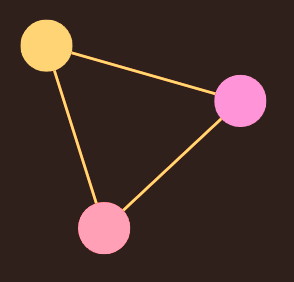

Here, we're using the coloured circles to represent the nodes and the yellow lines to represent the edges. In this case, we're looking at a fully connected graph - where each node is connected by an edge to each other node.

If we were to think about nodes in the context of LangGraph - we would think of a function

If we were to think about edges in the context of LangGraph - we might think of them as "paths to take" or "where to pass our state object next".

Let's create some nodes and expand on our diagram.

In [ ]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tools)

Now we have two total nodes. We have:

- `call_model` is a node that will...well...call the model
- `tool_node` is a node which can call a tool

Let's start adding nodes! We'll update our diagram along the way to keep track of what this looks like!


In [ ]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)

Let's look at what we have so far:

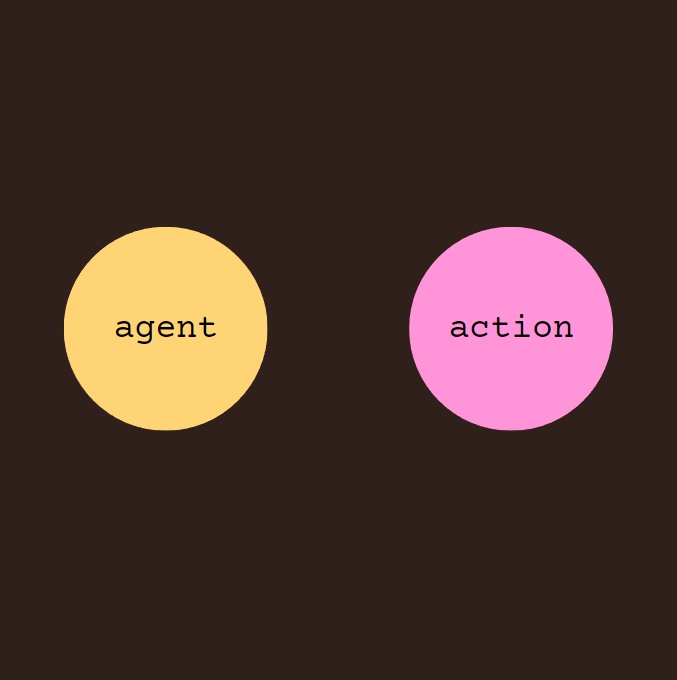

Next, we'll add our entrypoint. All our entrypoint does is indicate which node is called first.

In [ ]:
uncompiled_graph.set_entry_point("agent")

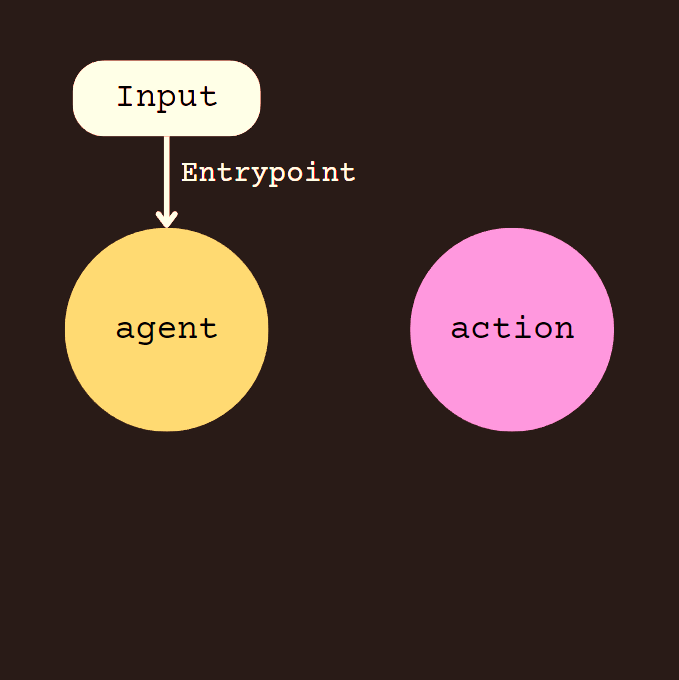

Now we want to build a "conditional edge" which will use the output state of a node to determine which path to follow.

We can help conceptualize this by thinking of our conditional edge as a conditional in a flowchart!

Notice how our function simply checks if there is a "function_call" kwarg present.

Then we create an edge where the origin node is our agent node and our destination node is *either* the action node or the END (finish the graph).

It's important to highlight that the dictionary passed in as the third parameter (the mapping) should be created with the possible outputs of our conditional function in mind. In this case `should_continue` outputs either `"end"` or `"continue"` which are subsequently mapped to the action node or the END node.

In [ ]:
def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

Let's visualize what this looks like.

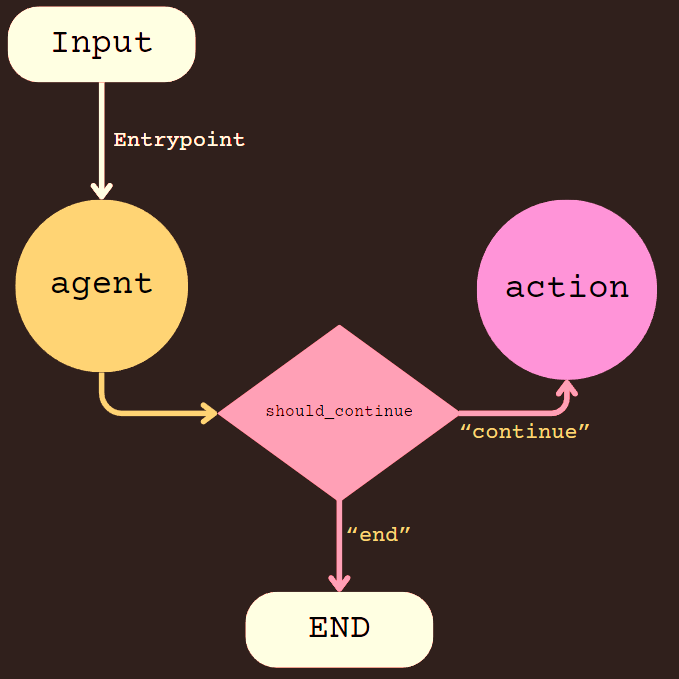

Finally, we can add our last edge which will connect our action node to our agent node. This is because we *always* want our action node (which is used to call our tools) to return its output to our agent!

In [ ]:
uncompiled_graph.add_edge("action", "agent")

All that's left to do now is to compile our workflow - and we're off!

In [ ]:
compiled_graph = uncompiled_graph.compile()

#### ❓ Question #2:

Is there any specific limit to how many times we can cycle?

- There are no limits to the number of cycles that can occur.

If not, how could we impose a limit to the number of cycles?

- One possible way to limit is user a counter variable perhaps in the state object to make sure that the number cycles do not exceed a certain number.

## Using Our Graph

Now that we've created and compiled our graph - we can call simply it

Let's try out a few examples to see how it fairs:

In [ ]:
from langchain_core.messages import HumanMessage

inputs = {"messages" : [HumanMessage(content="What is the current weather in New York?")]}

async for chunk in compiled_graph.astream(inputs, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Let's look at what happened:

1. Our state object was populated with our request
2. The state object was passed into agent node and the agent node added an `AIMessage` to the state object and passed it along the conditional edge
3. The conditional edge received the state object, found the "tool_calls" `additional_kwarg`, and sent the state object to the action node
4. The action node added the response from the OpenAI function calling endpoint to the state object and passed it along the edge to the agent node
5. The agent node added a response to the state object and passed it along the conditional edge
6. The conditional edge received the state object, could not find the "tool_calls" `additional_kwarg` and passed the state object to END where we see it output in the cell above!

Now let's look at an example that shows a multiple tool usage - all with the same flow!